## 策略网络

In [12]:
import  gym,os
import  numpy as np
import  matplotlib
from    matplotlib import pyplot as plt
# Default parameters for plots
matplotlib.rcParams['font.size'] = 18
matplotlib.rcParams['figure.titlesize'] = 18
matplotlib.rcParams['figure.figsize'] = [9, 7]
matplotlib.rcParams['font.family'] = ['KaiTi']
matplotlib.rcParams['axes.unicode_minus']=False 

import  tensorflow as tf
from    tensorflow import keras
from    tensorflow.keras import layers,optimizers,losses
from    PIL import Image
env = gym.make('CartPole-v1')  # 创建游戏环境
env.seed(2333)
tf.random.set_seed(2333)
np.random.seed(2333)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
assert tf.__version__.startswith('2.')

learning_rate = 0.0002
gamma         = 0.98

In [48]:
# import gym
# env = gym.make("CartPole-v1") # 创建游戏环境
# observation = env.reset() # 游戏回到初始状态
# for _ in range(1000):
#     env.render() # 显示当前时间戳的游戏画面
#     action = env.action_space.sample() # 随机生成一个动作
#     # 与环境交互，返回新的状态，奖励，是否结束标志，其他信息
#     observation, reward, done, info = env.step(action)
#     if done:#游戏回合结束，复位状态
#         observation = env.reset()
# env.close()

In [13]:
class Policy(keras.Model):
    # 策略网络，生成动作的概率分布
    def __init__(self):
        super(Policy, self).__init__()
        self.data = [] # 存储轨迹
        # 输入为长度为4的向量，输出为左、右2个动作
        self.fc1 = layers.Dense(128, kernel_initializer='he_normal')
        self.fc2 = layers.Dense(2, kernel_initializer='he_normal')
        # 网络优化器
        self.optimizer = optimizers.Adam(lr=learning_rate)

    def call(self, inputs, training=None):
        # 状态输入s的shape为向量：[4]
        x = tf.nn.relu(self.fc1(inputs))
        x = tf.nn.softmax(self.fc2(x), axis=1)
        return x

    def put_data(self, item):
        # 记录r,log_P(a|s)
        self.data.append(item)

    def train_net(self, tape):
        # 计算梯度并更新策略网络参数。tape为梯度记录器
        R = 0 # 终结状态的初始回报为0
        for r, log_prob in self.data[::-1]:#逆序取
            R = r + gamma * R # 计算每个时间戳上的回报
            # 每个时间戳都计算一次梯度
            # grad_R=-log_P*R*grad_theta
            loss = -log_prob * R
            with tape.stop_recording():
                # 优化策略网络
                grads = tape.gradient(loss, self.trainable_variables)
                # print(grads)
                self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.data = [] # 清空轨迹


In [14]:
def main():
    # 创建策略网络
    pi(tf.random.normal((4,4)))
    pi.summary()
    score = 0.0 # 计分
    print_interval = 20 # 打印间隔
    returns = []
    best_score=0.0
    for n_epi in range(400):
        s = env.reset() # 回到游戏初始状态，返回s0
        with tf.GradientTape(persistent=True) as tape:
            for t in range(501): # CartPole-v1 forced to terminates at 500 step.
                # 送入状态向量，获取策略
                s = tf.constant(s,dtype=tf.float32)
                # s: [4] => [1,4]
                s = tf.expand_dims(s, axis=0)
                prob = pi(s) # 动作分布:[1,2]
                # 从类别分布中采样1个动作, shape: [1]
                a = tf.random.categorical(tf.math.log(prob), 1)[0]
                a = int(a) # Tensor转数字
                s_prime, r, done, info = env.step(a)
                # 记录动作a和动作产生的奖励r
                # prob shape:[1,2]
                pi.put_data((r, tf.math.log(prob[0][a])))
                s = s_prime # 刷新状态
                score += r # 累积奖励

                if n_epi >1000:
                    env.render()
                    # im = Image.fromarray(s)
                    # im.save("res/%d.jpg" % info['frames'][0])

                if done:  # 当前episode终止
                    break
            # episode终止后，训练一次网络
            pi.train_net(tape)
        del tape

        if n_epi%print_interval==0 and n_epi!=0:
            if best_score<=score/print_interval:
                best_score=score/print_interval
                pi.save_weights('./model14/model1/model1')
                print("Save model")
            returns.append(score/print_interval)
            print(f"# of episode :{n_epi}, avg score : {score/print_interval}")
            score = 0.0
    env.close() # 关闭环境

    plt.plot(np.arange(len(returns))*print_interval, returns)
    plt.plot(np.arange(len(returns))*print_interval, returns, 's')
    plt.xlabel('回合数')
    plt.ylabel('总回报')
    plt.savefig('reinforce-tf-cartpole.svg')

Model: "policy"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              multiple                  640       
_________________________________________________________________
dense_5 (Dense)              multiple                  258       
Total params: 898
Trainable params: 898
Non-trainable params: 0
_________________________________________________________________
Save model
# of episode :20, avg score : 72.9
Save model
# of episode :40, avg score : 109.25
# of episode :60, avg score : 107.8
Save model
# of episode :80, avg score : 170.35
Save model
# of episode :100, avg score : 234.65
# of episode :120, avg score : 222.45
# of episode :140, avg score : 161.5
Save model
# of episode :160, avg score : 328.1
# of episode :180, avg score : 285.6
Save model
# of episode :200, avg score : 355.4
# of episode :220, avg score : 329.7
Save model
# of episode :240, avg score : 360.1
Save

<IPython.core.display.Javascript object>


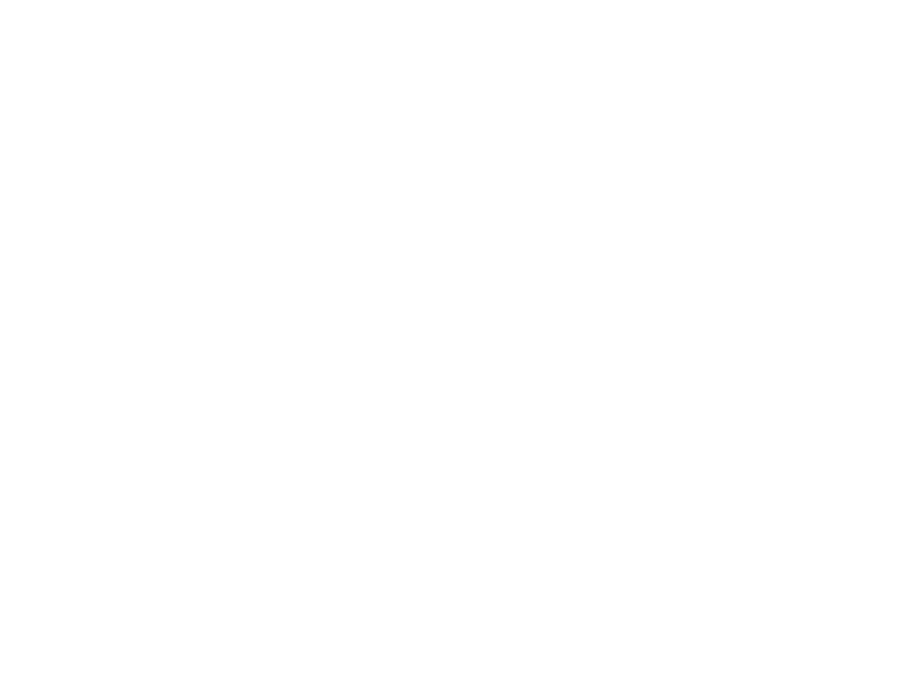

In [22]:
if __name__ == '__main__':
    pi = Policy() 
    main()

In [15]:
pi = Policy() 
pi.load_weights('./model14/model1/model1')

In [16]:
%matplotlib nbagg
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt

In [17]:
from PIL import Image, ImageDraw

try:
    from pyglet.gl import gl_info
    openai_cart_pole_rendering = True   # no problem, let's use OpenAI gym's rendering function
except Exception:
    openai_cart_pole_rendering = False  # probably no X server available, let's use our own rendering function

def render_cart_pole(env, obs):
    if openai_cart_pole_rendering:
        # use OpenAI gym's rendering function
        return env.render(mode="rgb_array")
    else:
        # rendering for the cart pole environment (in case OpenAI gym can't do it)
        img_w = 600
        img_h = 400
        cart_w = img_w // 12
        cart_h = img_h // 15
        pole_len = img_h // 3.5
        pole_w = img_w // 80 + 1
        x_width = 2
        max_ang = 0.2
        bg_col = (255, 255, 255)
        cart_col = 0x000000 # Blue Green Red
        pole_col = 0x669acc # Blue Green Red

        pos, vel, ang, ang_vel = obs
        img = Image.new('RGB', (img_w, img_h), bg_col)
        draw = ImageDraw.Draw(img)
        cart_x = pos * img_w // x_width + img_w // x_width
        cart_y = img_h * 95 // 100
        top_pole_x = cart_x + pole_len * np.sin(ang)
        top_pole_y = cart_y - cart_h // 2 - pole_len * np.cos(ang)
        draw.line((0, cart_y, img_w, cart_y), fill=0)
        draw.rectangle((cart_x - cart_w // 2, cart_y - cart_h // 2, cart_x + cart_w // 2, cart_y + cart_h // 2), fill=cart_col) # draw cart
        draw.line((cart_x, cart_y - cart_h // 2, top_pole_x, top_pole_y), fill=pole_col, width=pole_w) # draw pole
        return np.array(img)

def plot_cart_pole(env, obs):
    plt.close()  # or else nbagg sometimes plots in the previous cell
    img = render_cart_pole(env, obs)
    plt.imshow(img)
    plt.axis("off")
    plt.show()

In [18]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    plt.close()  # or else nbagg sometimes plots in the previous cell
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    return animation.FuncAnimation(fig, update_scene, fargs=(frames, patch), frames=len(frames), repeat=repeat, interval=interval)

## 测试

In [21]:
n_max_steps = 500
frames = []

obs = env.reset()
for step in range(n_max_steps):
    img = render_cart_pole(env, obs)
    frames.append(img)
    # 送入状态向量，获取策略
    s = tf.constant(obs,dtype=tf.float32)
    # s: [4] => [1,4]
    s = tf.expand_dims(s, axis=0)
    prob = pi(s)
    # 从类别分布中采样1个动作, shape: [1]
    a = tf.random.categorical(tf.math.log(prob), 1)[0]
    a = int(a) # Tensor转数字
    s_prime, r, done, info = env.step(a)
    if done:
        break

env.close()

<IPython.core.display.Javascript object>


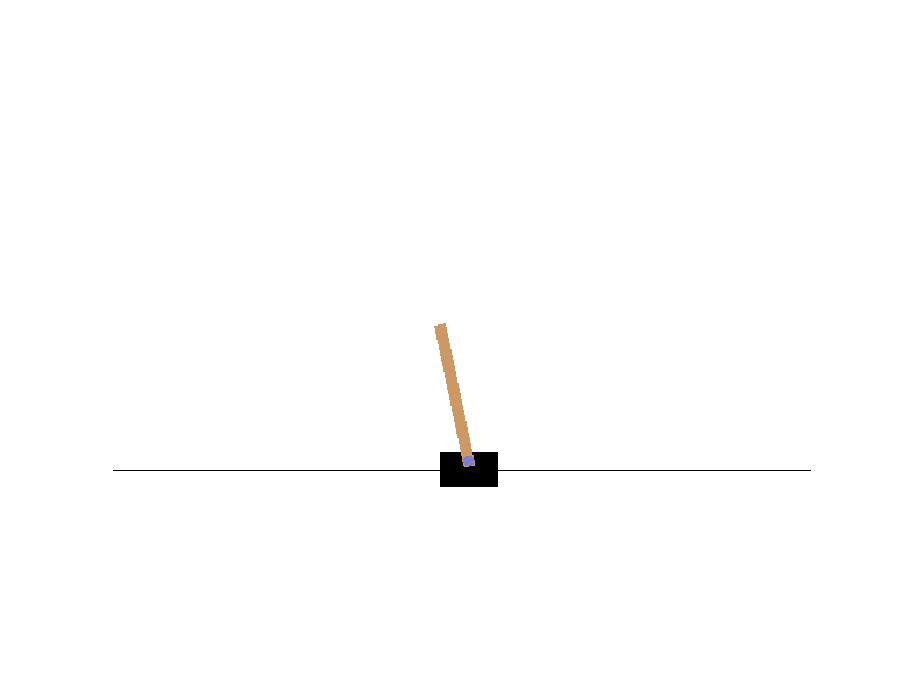

In [22]:
video = plot_animation(frames)
plt.show()

## PPO

In [23]:
import  gym,os
import  numpy as np
import  tensorflow as tf
from    tensorflow import keras
from    tensorflow.keras import layers,optimizers,losses
from    collections import namedtuple
from    torch.utils.data import SubsetRandomSampler,BatchSampler

env = gym.make('CartPole-v1')  # 创建游戏环境
env.seed(2222)
tf.random.set_seed(2222)
np.random.seed(2222)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
assert tf.__version__.startswith('2.')

In [24]:
gamma = 0.98 # 激励衰减因子
epsilon = 0.2 # PPO误差超参数0.8~1.2
batch_size = 32 # batch size


# 创建游戏环境
env = gym.make('CartPole-v0').unwrapped
Transition = namedtuple('Transition', ['state', 'action', 'a_log_prob', 'reward', 'next_state'])

In [25]:
class Actor(keras.Model):
    def __init__(self):
        super(Actor, self).__init__()
        # 策略网络，也叫Actor网络，输出为概率分布pi(a|s)
        self.fc1 = layers.Dense(100, kernel_initializer='he_normal')
        self.fc2 = layers.Dense(2, kernel_initializer='he_normal')

    def call(self, inputs):
        x = tf.nn.relu(self.fc1(inputs))
        x = self.fc2(x)
        x = tf.nn.softmax(x, axis=1) # 转换成概率
        return x

In [26]:
class Critic(keras.Model):
    def __init__(self):
        super(Critic, self).__init__()
        # 偏置b的估值网络，也叫Critic网络，输出为v(s)
        self.fc1 = layers.Dense(100, kernel_initializer='he_normal')
        self.fc2 = layers.Dense(1, kernel_initializer='he_normal')

    def call(self, inputs):
        x = tf.nn.relu(self.fc1(inputs))
        x = self.fc2(x)
        return x

In [27]:
class PPO():
    # PPO算法主体
    def __init__(self):
        super(PPO, self).__init__()
        self.actor = Actor() # 创建Actor网络
        self.critic = Critic() # 创建Critic网络
        self.buffer = [] # 数据缓冲池
        self.actor_optimizer = optimizers.Adam(1e-3) # Actor优化器
        self.critic_optimizer = optimizers.Adam(3e-3) # Critic优化器

    def select_action(self, s):
        # 送入状态向量，获取策略: [4]
        s = tf.constant(s, dtype=tf.float32)
        # s: [4] => [1,4]
        s = tf.expand_dims(s, axis=0)
        # 获取策略分布: [1, 2]
        prob = self.actor(s)
        # 从类别分布中采样1个动作, shape: [1]
        a = tf.random.categorical(tf.math.log(prob), 1)[0]
        a = int(a)  # Tensor转数字
        return a, float(prob[0][a]) # 返回动作及其概率

    def get_value(self, s):
        # 送入状态向量，获取策略: [4]
        s = tf.constant(s, dtype=tf.float32)
        # s: [4] => [1,4]
        s = tf.expand_dims(s, axis=0)
        # 获取策略分布: [1, 2]
        v = self.critic(s)[0]
        return float(v) # 返回v(s)

    def store_transition(self, transition):
        # 存储采样数据
        self.buffer.append(transition)
    
    def save_weights(self,path):
        actor_path=os.path.join(path,"Actor")
        critic_path=os.path.join(path,"Critic")
        self.actor.save_weights(actor_path)
        self.critic.save_weights(critic_path)
    
    def load_weights(self,path):
        actor_path=os.path.join(path,"Actor")
        critic_path=os.path.join(path,"Critic")
        self.actor.load_weights(actor_path)
        self.critic.load_weights(critic_path)
    
    def optimize(self):
        # 优化网络主函数
        # 从缓存中取出样本数据，转换成Tensor
        state = tf.constant([t.state for t in self.buffer], dtype=tf.float32)
        action = tf.constant([t.action for t in self.buffer], dtype=tf.int32)
        action = tf.reshape(action,[-1,1])
        reward = [t.reward for t in self.buffer]
        old_action_log_prob = tf.constant([t.a_log_prob for t in self.buffer], dtype=tf.float32)
        old_action_log_prob = tf.reshape(old_action_log_prob, [-1,1])
        # 通过MC方法循环计算R(st)
        R = 0
        Rs = []
        for r in reward[::-1]:
            R = r + gamma * R
            Rs.insert(0, R)
        Rs = tf.constant(Rs, dtype=tf.float32)
        # 对缓冲池数据大致迭代10遍
        for _ in range(round(10*len(self.buffer)/batch_size)):
            # 随机从缓冲池采样batch size大小样本
            index = np.random.choice(np.arange(len(self.buffer)), batch_size, replace=False)
            # 构建梯度跟踪环境
            with tf.GradientTape() as tape1, tf.GradientTape() as tape2:
                # 取出R(st)，[b,1]
                v_target = tf.expand_dims(tf.gather(Rs, index, axis=0), axis=1)
                # 计算v(s)预测值，也就是偏置b，我们后面会介绍为什么写成v
                v = self.critic(tf.gather(state, index, axis=0))
                delta = v_target - v # 计算优势值
                advantage = tf.stop_gradient(delta) # 断开梯度连接 
                # 由于TF的gather_nd与pytorch的gather功能不一样，需要构造
                # gather_nd需要的坐标参数，indices:[b, 2]
                # pi_a = pi.gather(1, a) # pytorch只需要一行即可实现
                a = tf.gather(action, index, axis=0) # 取出batch的动作at
                # batch的动作分布pi(a|st)
                pi = self.actor(tf.gather(state, index, axis=0)) 
                indices = tf.expand_dims(tf.range(a.shape[0]), axis=1)
                indices = tf.concat([indices, a], axis=1)
                pi_a = tf.gather_nd(pi, indices)  # 动作的概率值pi(at|st), [b]
                pi_a = tf.expand_dims(pi_a, axis=1)  # [b]=> [b,1] 
                # 重要性采样
                ratio = (pi_a / tf.gather(old_action_log_prob, index, axis=0))
                surr1 = ratio * advantage
                surr2 = tf.clip_by_value(ratio, 1 - epsilon, 1 + epsilon) * advantage
                # PPO误差函数
                policy_loss = -tf.reduce_mean(tf.minimum(surr1, surr2))
                # 对于偏置v来说，希望与MC估计的R(st)越接近越好
                value_loss = losses.MSE(v_target, v)
            # 优化策略网络
            grads = tape1.gradient(policy_loss, self.actor.trainable_variables)
            self.actor_optimizer.apply_gradients(zip(grads, self.actor.trainable_variables))
            # 优化偏置值网络
            grads = tape2.gradient(value_loss, self.critic.trainable_variables)
            self.critic_optimizer.apply_gradients(zip(grads, self.critic.trainable_variables))

        self.buffer = []  # 清空已训练数据

In [28]:
def main():
    returns = [] # 统计总回报
    total = 0 # 一段时间内平均回报
    best_score=0.0
    for i_epoch in range(500): # 训练回合数
        state = env.reset() # 复位环境
        for t in range(500): # 最多考虑500步
            # 通过最新策略与环境交互
            action, action_prob = agent.select_action(state)
            next_state, reward, done, _ = env.step(action)
            # 构建样本并存储
            trans = Transition(state, action, action_prob, reward, next_state)
            agent.store_transition(trans)
            state = next_state # 刷新状态
            total += reward # 累积激励
            if done: # 合适的时间点训练网络
                if len(agent.buffer) >= batch_size:
                    agent.optimize() # 训练网络
                break

        if i_epoch % 20 == 0: # 每20个回合统计一次平均回报
            if total/20>best_score:
                best_score=total/20
                agent.save_weights("./model14/model2")
                print("Save model!")
            returns.append(total/20)
            total = 0
            print(i_epoch, returns[-1])

    print(np.array(returns))
    plt.figure()
    plt.plot(np.arange(len(returns))*20, np.array(returns))
    plt.plot(np.arange(len(returns))*20, np.array(returns), 's')
    plt.xlabel('回合数')
    plt.ylabel('总回报')
    plt.savefig('ppo-tf-cartpole.svg')

Save model!
0 1.7
Save model!
20 13.05
40 11.1
60 12.6
Save model!
80 13.75
Save model!
100 15.2
Save model!
120 16.35
Save model!
140 19.75
Save model!
160 38.85
Save model!
180 154.25
Save model!
200 276.55
Save model!
220 420.2
Save model!
240 482.1
Save model!
260 493.85
Save model!
280 495.75
300 494.6
Save model!
320 500.0
340 500.0
360 500.0
380 500.0
400 500.0
420 497.1
440 500.0
460 500.0
480 500.0
[  1.7   13.05  11.1   12.6   13.75  15.2   16.35  19.75  38.85 154.25
 276.55 420.2  482.1  493.85 495.75 494.6  500.   500.   500.   500.
 500.   497.1  500.   500.   500.  ]


<IPython.core.display.Javascript object>


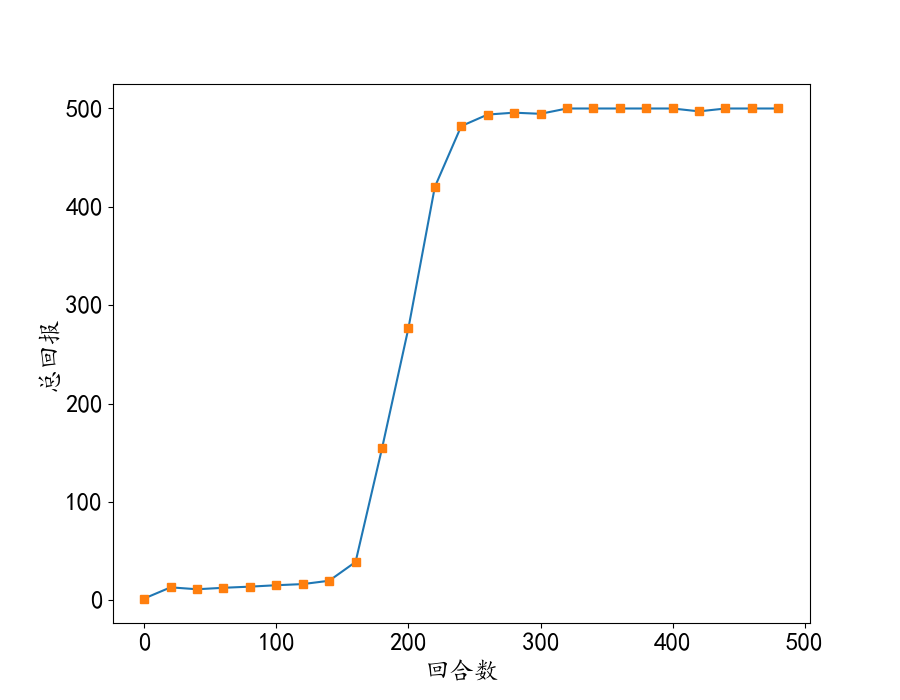

end


In [50]:
agent = PPO()
main()
print("end")

## 测试

In [49]:
agent = PPO()
agent.load_weights("./model14/model2")

In [50]:
n_max_steps = 1000
frames = []

state = env.reset()
for step in range(n_max_steps):
    img = render_cart_pole(env, state)
    frames.append(img)
    # 送入状态向量，获取策略
    action, action_prob = agent.select_action(state)
    next_state, reward, done, _ = env.step(action)
    state = next_state # 刷新状态
    if done:
        break

env.close()

<IPython.core.display.Javascript object>


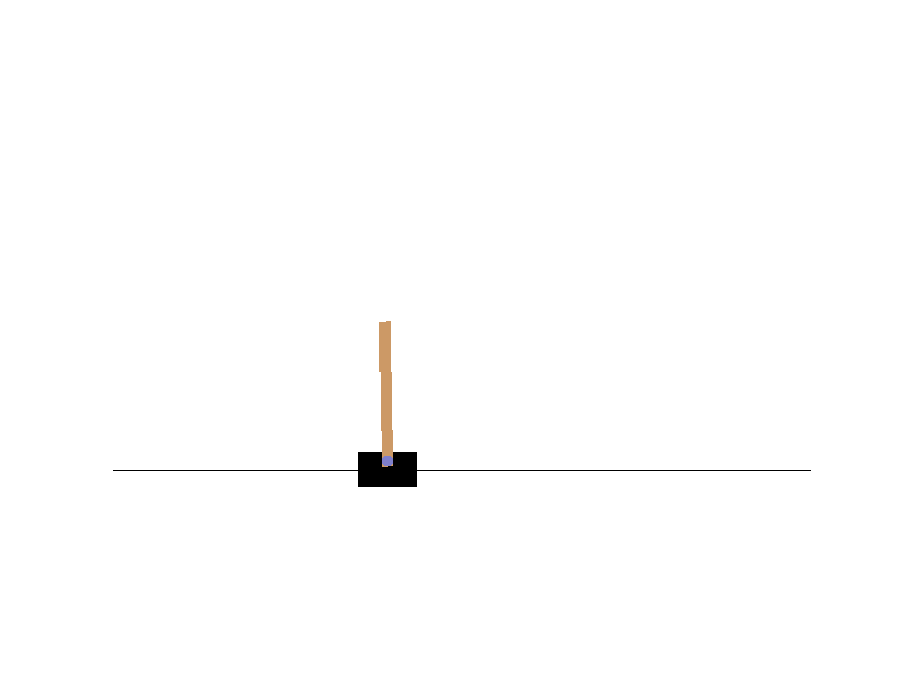

In [31]:
video = plot_animation(frames)
plt.show()

## DQN

In [32]:
import collections
import random
import gym,os
import  numpy as np
import  tensorflow as tf
from    tensorflow import keras
from    tensorflow.keras import layers,optimizers,losses

In [33]:
env = gym.make('CartPole-v1')  # 创建游戏环境
env.seed(1234)
tf.random.set_seed(1234)
np.random.seed(1234)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
assert tf.__version__.startswith('2.')

In [34]:
# Hyperparameters
learning_rate = 0.0002
gamma = 0.99
buffer_limit = 50000
batch_size = 32

In [35]:
class ReplayBuffer():
    # 经验回放池
    def __init__(self):
        # 双向队列
        self.buffer = collections.deque(maxlen=buffer_limit)

    def put(self, transition):
        self.buffer.append(transition)

    def sample(self, n):
        # 从回放池采样n个5元组
        mini_batch = random.sample(self.buffer, n)
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []
        # 按类别进行整理
        for transition in mini_batch:
            s, a, r, s_prime, done_mask = transition
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            done_mask_lst.append([done_mask])
        # 转换成Tensor
        return tf.constant(s_lst, dtype=tf.float32),\
                      tf.constant(a_lst, dtype=tf.int32), \
                      tf.constant(r_lst, dtype=tf.float32), \
                      tf.constant(s_prime_lst, dtype=tf.float32), \
                      tf.constant(done_mask_lst, dtype=tf.float32)


    def size(self):
        return len(self.buffer)


In [36]:
class Qnet(keras.Model):
    def __init__(self):
        # 创建Q网络，输入为状态向量，输出为动作的Q值
        super(Qnet, self).__init__()
        self.fc1 = layers.Dense(256, kernel_initializer='he_normal')
        self.fc2 = layers.Dense(256, kernel_initializer='he_normal')
        self.fc3 = layers.Dense(2, kernel_initializer='he_normal')

    def call(self, x, training=None):
        x = tf.nn.relu(self.fc1(x))
        x = tf.nn.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def sample_action(self, s, epsilon):
        # 送入状态向量，获取策略: [4]
        s = tf.constant(s, dtype=tf.float32)
        # s: [4] => [1,4]
        s = tf.expand_dims(s, axis=0)
        out = self(s)[0]
        coin = random.random()
        # 策略改进：e-贪心方式
        if coin < epsilon:
            # epsilon大的概率随机选取
            return random.randint(0, 1)
        else:  # 选择Q值最大的动作
            return int(tf.argmax(out))


In [37]:
def train(q, q_target, memory, optimizer):
    # 通过Q网络和影子网络来构造贝尔曼方程的误差，
    # 并只更新Q网络，影子网络的更新会滞后Q网络
    huber = losses.Huber()
    for i in range(10):  # 训练10次
        # 从缓冲池采样
        s, a, r, s_prime, done_mask = memory.sample(batch_size)
        with tf.GradientTape() as tape:
            # s: [b, 4]
            q_out = q(s)  # 得到Q(s,a)的分布
            # 由于TF的gather_nd与pytorch的gather功能不一样，需要构造
            # gather_nd需要的坐标参数，indices:[b, 2]
            # pi_a = pi.gather(1, a) # pytorch只需要一行即可实现
            indices = tf.expand_dims(tf.range(a.shape[0]), axis=1)
            indices = tf.concat([indices, a], axis=1)
            q_a = tf.gather_nd(q_out, indices) # 动作的概率值, [b]
            q_a = tf.expand_dims(q_a, axis=1) # [b]=> [b,1]
            # 得到Q(s',a)的最大值，它来自影子网络！ [b,4]=>[b,2]=>[b,1]
            max_q_prime = tf.reduce_max(q_target(s_prime),axis=1,keepdims=True)
            # 构造Q(s,a_t)的目标值，来自贝尔曼方程
            target = r + gamma * max_q_prime * done_mask
            # 计算Q(s,a_t)与目标值的误差
            loss = huber(q_a, target)
        # 更新网络，使得Q(s,a_t)估计符合贝尔曼方程
        grads = tape.gradient(loss, q.trainable_variables)
        # for p in grads:
        #     print(tf.norm(p))
        # print(grads)
        optimizer.apply_gradients(zip(grads, q.trainable_variables))

In [38]:
def main():
    env = gym.make('CartPole-v1')  # 创建环境
    q = Qnet()  # 创建Q网络
    q_target = Qnet()  # 创建影子网络
    q.build(input_shape=(2,4))
    q_target.build(input_shape=(2,4))
    for src, dest in zip(q.variables, q_target.variables):
        dest.assign(src) # 影子网络权值来自Q
    memory = ReplayBuffer()  # 创建回放池

    print_interval = 20
    score = 0.0
    optimizer = optimizers.Adam(lr=learning_rate)
    best_score=0.0
    for n_epi in range(6000):  # 训练次数
        # epsilon概率也会8%到1%衰减，越到后面越使用Q值最大的动作
        epsilon = max(0.01, 0.08 - 0.01 * (n_epi / 200))
        s = env.reset()  # 复位环境
        for t in range(600):  # 一个回合最大时间戳
            # if n_epi>1000:
            #     env.render()
            # 根据当前Q网络提取策略，并改进策略
            a = q.sample_action(s, epsilon)
            # 使用改进的策略与环境交互
            s_prime, r, done, info = env.step(a)
            done_mask = 0.0 if done else 1.0  # 结束标志掩码
            # 保存5元组
            memory.put((s, a, r / 100.0, s_prime, done_mask))
            s = s_prime  # 刷新状态
            score += r  # 记录总回报
            if done:  # 回合结束
                break

        if memory.size() > 2000:  # 缓冲池只有大于2000就可以训练
            train(q, q_target, memory, optimizer)

        if n_epi % print_interval == 0 and n_epi != 0:
            for src, dest in zip(q.variables, q_target.variables):
                dest.assign(src)  # 影子网络权值来自Q
#                 应该 >=
            if score>=best_score:
                best_score=score
                q.save_weights("./model14/model3/model3")
                print("save model!")
            print("# of episode :{}, avg score : {:.1f}, buffer size : {}, " \
                  "epsilon : {:.1f}%" \
                  .format(n_epi, score / print_interval, memory.size(), epsilon * 100))
            score = 0.0
    env.close()

In [37]:
main()

save model!
# of episode :20, avg score : 10.3, buffer size : 207, epsilon : 7.9%
# of episode :40, avg score : 9.9, buffer size : 406, epsilon : 7.8%
# of episode :60, avg score : 9.8, buffer size : 601, epsilon : 7.7%
# of episode :80, avg score : 9.8, buffer size : 798, epsilon : 7.6%
# of episode :100, avg score : 10.0, buffer size : 998, epsilon : 7.5%
# of episode :120, avg score : 9.4, buffer size : 1187, epsilon : 7.4%
# of episode :140, avg score : 9.2, buffer size : 1370, epsilon : 7.3%
# of episode :160, avg score : 9.9, buffer size : 1568, epsilon : 7.2%
# of episode :180, avg score : 10.1, buffer size : 1770, epsilon : 7.1%
# of episode :200, avg score : 9.7, buffer size : 1964, epsilon : 7.0%
save model!
# of episode :220, avg score : 11.2, buffer size : 2189, epsilon : 6.9%
# of episode :240, avg score : 9.2, buffer size : 2372, epsilon : 6.8%
# of episode :260, avg score : 9.9, buffer size : 2571, epsilon : 6.7%
# of episode :280, avg score : 9.6, buffer size : 2763, ep

# of episode :2240, avg score : 70.3, buffer size : 50000, epsilon : 1.0%
# of episode :2260, avg score : 70.2, buffer size : 50000, epsilon : 1.0%
# of episode :2280, avg score : 82.5, buffer size : 50000, epsilon : 1.0%
# of episode :2300, avg score : 84.5, buffer size : 50000, epsilon : 1.0%
# of episode :2320, avg score : 75.7, buffer size : 50000, epsilon : 1.0%
# of episode :2340, avg score : 48.5, buffer size : 50000, epsilon : 1.0%
# of episode :2360, avg score : 62.0, buffer size : 50000, epsilon : 1.0%
# of episode :2380, avg score : 81.3, buffer size : 50000, epsilon : 1.0%
# of episode :2400, avg score : 92.2, buffer size : 50000, epsilon : 1.0%
# of episode :2420, avg score : 58.5, buffer size : 50000, epsilon : 1.0%
# of episode :2440, avg score : 89.0, buffer size : 50000, epsilon : 1.0%
# of episode :2460, avg score : 64.8, buffer size : 50000, epsilon : 1.0%
# of episode :2480, avg score : 97.3, buffer size : 50000, epsilon : 1.0%
# of episode :2500, avg score : 90.4, 

# of episode :4460, avg score : 151.9, buffer size : 50000, epsilon : 1.0%
# of episode :4480, avg score : 105.2, buffer size : 50000, epsilon : 1.0%
# of episode :4500, avg score : 98.8, buffer size : 50000, epsilon : 1.0%
# of episode :4520, avg score : 77.7, buffer size : 50000, epsilon : 1.0%
# of episode :4540, avg score : 84.7, buffer size : 50000, epsilon : 1.0%
# of episode :4560, avg score : 118.0, buffer size : 50000, epsilon : 1.0%
# of episode :4580, avg score : 87.5, buffer size : 50000, epsilon : 1.0%
# of episode :4600, avg score : 123.4, buffer size : 50000, epsilon : 1.0%
# of episode :4620, avg score : 94.4, buffer size : 50000, epsilon : 1.0%
# of episode :4640, avg score : 101.3, buffer size : 50000, epsilon : 1.0%
# of episode :4660, avg score : 87.8, buffer size : 50000, epsilon : 1.0%
# of episode :4680, avg score : 104.2, buffer size : 50000, epsilon : 1.0%
# of episode :4700, avg score : 90.6, buffer size : 50000, epsilon : 1.0%
# of episode :4720, avg score : 

In [39]:
q = Qnet()  # 创建Q网络
q.load_weights("./model14/model3/model3")

In [40]:
n_max_steps = 1000
frames = []

state = env.reset()
for step in range(n_max_steps):
    img = render_cart_pole(env, state)
    frames.append(img)
    # 送入状态向量，获取策略
    action = q.sample_action(state, 0)
    next_state, r, done, info = env.step(action)
    state = next_state # 刷新状态
    if done:
        break

env.close()

<IPython.core.display.Javascript object>


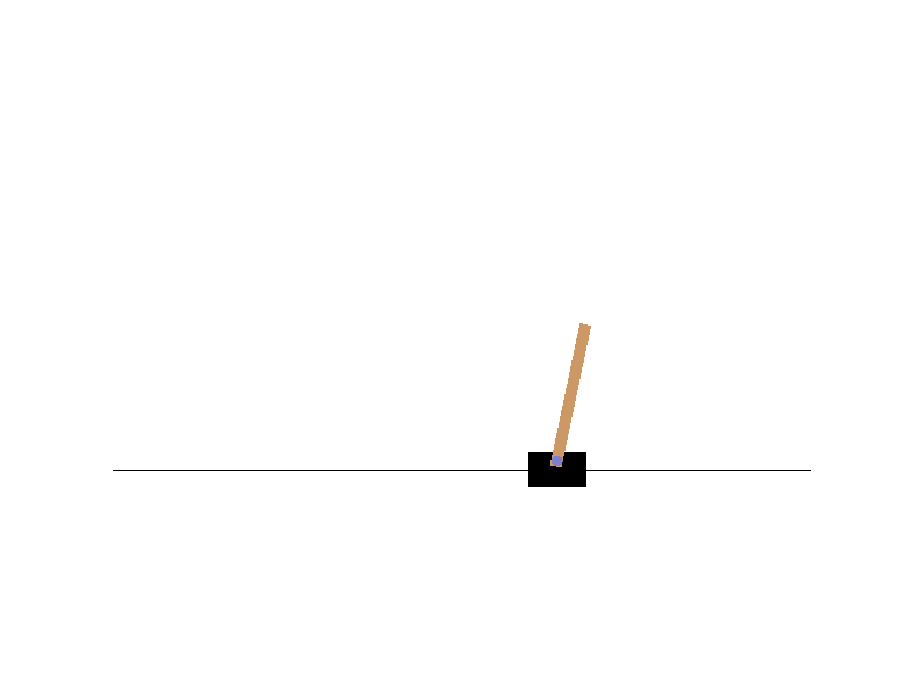

In [41]:
video = plot_animation(frames)
plt.show()

## A3C

In [42]:
import  threading
import  gym
import  multiprocessing
import  numpy as np
from    queue import Queue
import  matplotlib.pyplot as plt

import  tensorflow as tf
from    tensorflow import keras
from    tensorflow.keras import layers,optimizers,losses


In [43]:
tf.random.set_seed(1231)
np.random.seed(1231)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
assert tf.__version__.startswith('2.')

In [44]:
class ActorCritic(keras.Model):
    # Actor-Critic模型
    def __init__(self, state_size, action_size):
        super(ActorCritic, self).__init__()
        self.state_size = state_size # 状态向量长度
        self.action_size = action_size # 动作数量
        # 策略网络Actor
        self.dense1 = layers.Dense(128, activation='relu')
        self.policy_logits = layers.Dense(action_size)
        # V网络Critic
        self.dense2 = layers.Dense(128, activation='relu')
        self.values = layers.Dense(1)

    def call(self, inputs):
        # 获得策略分布Pi(a|s)
        x = self.dense1(inputs)
        logits = self.policy_logits(x)
        # 获得v(s)
        v = self.dense2(inputs)
        values = self.values(v)
        return logits, values

In [5]:
def record(episode,
           episode_reward,
           worker_idx,
           global_ep_reward,
           result_queue,
           total_loss,
           num_steps):
    # 统计工具函数
    if global_ep_reward == 0:
        global_ep_reward = episode_reward
    else:
        global_ep_reward = global_ep_reward * 0.99 + episode_reward * 0.01
    print(
        f"{episode} | "
        f"Average Reward: {int(global_ep_reward)} | "
        f"Episode Reward: {int(episode_reward)} | "
        f"Loss: {int(total_loss / float(num_steps) * 1000) / 1000} | "
        f"Steps: {num_steps} | "
        f"Worker: {worker_idx}"
    )
    result_queue.put(global_ep_reward) # 保存回报，传给主线程
    return global_ep_reward

In [6]:
class Memory:
    def __init__(self):
        self.states = []
        self.actions = []
        self.rewards = []

    def store(self, state, action, reward):
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)

    def clear(self):
        self.states = []
        self.actions = []
        self.rewards = []

In [7]:
class Agent:
    # 智能体，包含了中央参数网络server
    def __init__(self):
        # server优化器，client不需要，直接从server拉取参数
        self.opt = optimizers.Adam(1e-3)
        # 中央模型，类似于参数服务器
        self.server = ActorCritic(4, 2) # 状态向量，动作数量
        self.server(tf.random.normal((2, 4)))
        
    def save(self,path):
        self.server.save_weights(path)
    def load(self,path):
        self.server.load_weights(path)
        
    def train(self):
        best_score=0.0
        res_queue = Queue() # 共享队列
        # 创建各个交互环境
        workers = [Worker(self.server, self.opt, res_queue, i)
                   for i in range(multiprocessing.cpu_count())]
        for i, worker in enumerate(workers):
            print("Starting worker {}".format(i))
            worker.start()
        # 统计并绘制总回报曲线
        returns = []
        while True:
            reward = res_queue.get()
            if reward is not None:
                if best_score<=reward:
                    best_score=reward
                    print("Save model!")
                    self.save("./model14/model4")
                returns.append(reward)
            else: # 结束标志
                break
        [w.join() for w in workers] # 等待线程退出 

        print(returns)
        plt.figure()
        plt.plot(np.arange(len(returns)), returns)
        # plt.plot(np.arange(len(moving_average_rewards)), np.array(moving_average_rewards), 's')
        plt.xlabel('回合数')
        plt.ylabel('总回报')
        plt.savefig('a3c-tf-cartpole.svg')

In [8]:
class Worker(threading.Thread): 
    def __init__(self,  server, opt, result_queue, idx):
        super(Worker, self).__init__()
        self.result_queue = result_queue # 共享队列
        self.server = server # 中央模型
        self.opt = opt # 中央优化器
        self.client = ActorCritic(4, 2) # 线程私有网络
        self.worker_idx = idx # 线程id
        self.env = gym.make('CartPole-v1').unwrapped
        self.ep_loss = 0.0

    def run(self): 
        mem = Memory() # 每个worker自己维护一个memory
        for epi_counter in range(500): # 未达到最大回合数
            current_state = self.env.reset() # 复位client游戏状态
            mem.clear()
            ep_reward = 0.
            ep_steps = 0  
            done = False
            while not done:
                # 获得Pi(a|s),未经softmax
                logits, _ = self.client(tf.constant(current_state[None, :],
                                         dtype=tf.float32))
                probs = tf.nn.softmax(logits)
                # 随机采样动作
                action = np.random.choice(2, p=probs.numpy()[0])
                new_state, reward, done, _ = self.env.step(action) # 交互 
                ep_reward += reward # 累加奖励
                mem.store(current_state, action, reward) # 记录
                ep_steps += 1 # 计算回合步数
                current_state = new_state # 刷新状态 

                if ep_steps >= 500 or done: # 最长步数500
                    # 计算当前client上的误差
                    with tf.GradientTape() as tape:
                        total_loss = self.compute_loss(done, new_state, mem) 
                    # 计算误差
                    grads = tape.gradient(total_loss, self.client.trainable_weights)
                    # 梯度提交到server，在server上更新梯度
                    self.opt.apply_gradients(zip(grads,
                                                 self.server.trainable_weights))
                    # 从server拉取最新的梯度
                    self.client.set_weights(self.server.get_weights())
                    mem.clear() # 清空Memory 
                    # 统计此回合回报
                    self.result_queue.put(ep_reward)
                    print(self.worker_idx, ep_reward)
                    break
        self.result_queue.put(None) # 结束线程

    def compute_loss(self,
                     done,
                     new_state,
                     memory,
                     gamma=0.99):
        if done:
            reward_sum = 0. # 终止状态的v(终止)=0
        else:
            reward_sum = self.client(tf.constant(new_state[None, :],
                                     dtype=tf.float32))[-1].numpy()[0]
        # 统计折扣回报
        discounted_rewards = []
        for reward in memory.rewards[::-1]:  # reverse buffer r
            reward_sum = reward + gamma * reward_sum
            discounted_rewards.append(reward_sum)
        discounted_rewards.reverse()
        # 获取状态的Pi(a|s)和v(s)
        logits, values = self.client(tf.constant(np.vstack(memory.states),
                                 dtype=tf.float32))
        # 计算advantage = R() - v(s)
        advantage = tf.constant(np.array(discounted_rewards)[:, None],
                                         dtype=tf.float32) - values
        # Critic网络损失
        value_loss = advantage ** 2
        # 策略损失
        policy = tf.nn.softmax(logits)
        policy_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(
                        labels=memory.actions, logits=logits)
        # 计算策略网络损失时，并不会计算V网络
        policy_loss = policy_loss * tf.stop_gradient(advantage)
        # Entropy Bonus
        entropy = tf.nn.softmax_cross_entropy_with_logits(labels=policy,
                                                          logits=logits)
        policy_loss = policy_loss - 0.01 * entropy
        # 聚合各个误差
        total_loss = tf.reduce_mean((0.5 * value_loss + policy_loss))
        return total_loss

In [ ]:
if __name__ == '__main__':
    master = Agent()
    master.train()

Starting worker 0
Starting worker 1
Starting worker 2
Starting worker 3
Starting worker 4
Starting worker 5
Starting worker 6
Starting worker 7
Starting worker 8
Starting worker 9
Starting worker 10
Starting worker 11
8 21.0
04 16.0
 16.0
3 21.0
67 26.0
 11.0
1 14.0
10 30.0
11 36.0
5 40.0
2 41.0
9 44.0
0 10.0
7 11.0
1 10.0
3 13.0
4 17.0
6 24.0
10 22.0
5 15.0
9 10.0
11 24.0
7 10.0
8 31.0
2 20.0
0 16.0
10 9.0
3 24.0
11 13.0
1 28.0
9 15.0
4 634.0 27.0

8 16.0
2 16.0
7 25.0
3 12.0
5 37.0
0 27.0
10 22.0
4 13.0
11 28.0
8 12.0
1 26.0
7 12.0
5 10.0
3 13.0
6 29.0
2 26.0
10 13.0
0 21.0
1 10.0
7 9.0
4 19.0
11 18.0
8 20.0
9 53.0
6 13.0
3 16.0
10 13.0
0 14.0
2 19.0
1 12.0
5 31.0
4 14.0
9 12.0
7 20.0
3 10.0
6 14.0
8 18.0
11 27.0
0 15.0
10 17.0
1 13.0
5 12.0
2 20.0
43 12.0
 16.0
7 16.0
11 11.0
9 24.0
6 19.0
810  15.0
25.0
1 17.0
4 11.0
52 20.0
 16.0
7 14.0
6 13.0
3 23.0
0 37.0
9 20.0
11 26.0
10 18.0
1 15.0
85 16.0
 21.0
7 20.0
4 27.0
3 13.0
0 16.0
6 22.0
2 34.0
9 16.0
8 12.0
11 20.0
7 11.0
5 15.0
10 

In [45]:
model = ActorCritic(4,2)
# master.load("./model14/model4/model4")

In [46]:
model.load_weights("./model14/model4/model4")

In [47]:
n_max_steps = 2000
frames = []
env = gym.make('CartPole-v1').unwrapped
current_state = env.reset()
for step in range(n_max_steps):
    img = render_cart_pole(env, current_state)
    frames.append(img)
    # 送入状态向量，获取策略
    logits, _ = model(tf.constant(current_state[None, :],
                                         dtype=tf.float32))
    probs = tf.nn.softmax(logits)
    # 随机采样动作
    action = np.random.choice(2, p=probs.numpy()[0])
    new_state, reward, done, _ = env.step(action) # 交互 
    current_state=new_state
    if done:
        break

env.close()

<IPython.core.display.Javascript object>


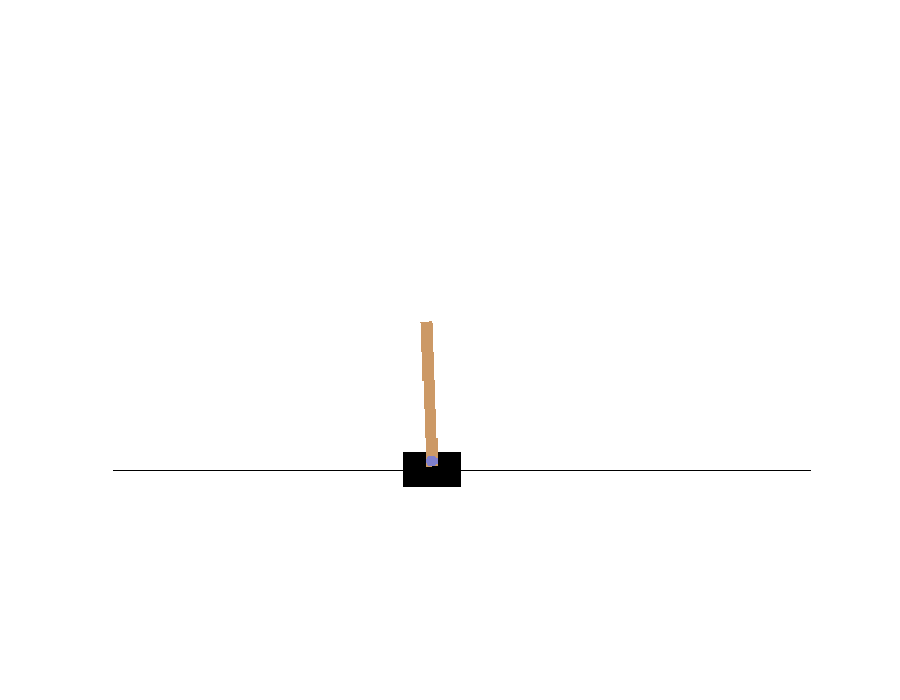

In [11]:
video = plot_animation(frames)
plt.show()